In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
def FindCorners(source, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(source)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        #print(ret)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

def CalibrateCamera(objpoints, imgpoints, img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist

def UnDistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradi = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(gradi)
    binary_output[(gradi >= thresh[0]) & (gradi <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_threshold(img, s_thresh=(170, 255), v_thresh=(170, 255)):
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    #l_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    #h_channel = hsv[:,:,0]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(s_binary == 1) & (v_binary == 1)] = 1
    
    return combined_binary

def Unwarp(bin_img):
       
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
   
        
    img_size = (bin_img.shape[1], bin_img.shape[0])
    
    bot_width = .76
    mid_width = .08
    height_pct = .62
    bottom_trim = .935
    offset = img_size[0]*.25
    src = np.float32([[bin_img.shape[1]*(.5-mid_width/2),bin_img.shape[0]*height_pct],[bin_img.shape[1]*(.5+mid_width/2),bin_img.shape[0]*height_pct],[bin_img.shape[1]*(.5+bot_width/2),bin_img.shape[0]*bottom_trim],[bin_img.shape[1]*(.5-bot_width/2),bin_img.shape[0]*bottom_trim]])
    
    dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset, img_size[1]]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(bin_img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped, Minv

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids


In [3]:
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y
source_path = "camera_cal/"
cal_objpoints = []
cal_imgpoints = []

source = 'camera_cal/calibration*.jpg'

cal_objpoints, cal_imgpoints = FindCorners(source, nx, ny)


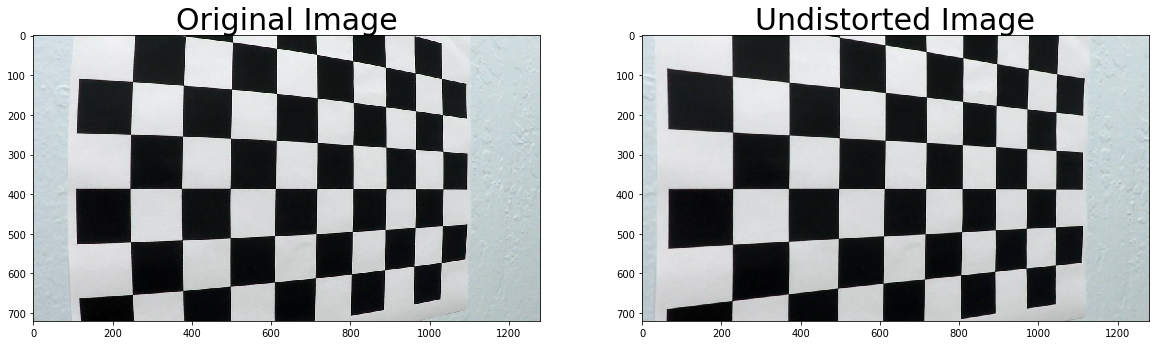

In [4]:
img = cv2.imread('camera_cal/calibration5.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist = CalibrateCamera(cal_objpoints, cal_imgpoints, img)


dst = UnDistort(img, mtx, dist)
cv2.imwrite('camera_cal/undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
"""dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )"""
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
images = glob.glob('test_images/test*.jpg')
#images = glob.glob('frame*.jpg')
ym_per_pix = 10/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension
xm_per_pix = 4/384 # meters per pixel in x dimension

window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching
    # Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = UnDistort(img, mtx, dist)
    write_name = 'test_images/undist'+str(idx)+'.jpg'
    cv2.imwrite(write_name,dst)
     # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', thresh=(20, 255))
    grady = abs_sobel_thresh(dst, orient='y', thresh=(20, 255))
    #mag_binary = mag_thresh(dst, sobel_kernel=9, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))

    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    binary_image = np.zeros_like(dst[:,:,0])
    
    color_bin = color_threshold(dst,s_thresh=(65, 255), v_thresh=(80, 255))
    binary_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 255
    
    write_name = 'test_images/binary'+str(idx)+'.jpg'
    cv2.imwrite(write_name,binary_image)
    
    warped, Minv = Unwarp(binary_image)
    write_name = 'test_images/warped'+str(idx)+'.jpg'
    cv2.imwrite(write_name,warped)
    
    leftx = []
    rightx = []
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            #print(window_centroids[level][0])
            #print(window_centroids[level][1])

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        write_name = 'test_images/markedwarped'+str(idx)+'.jpg'
        cv2.imwrite(write_name,output)
    
        yvals = range(0,warped.shape[0])
        res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
        
        left_fit = np.polyfit(res_yvals, leftx, 2)
        left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)

        left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        
        road = np.zeros_like(dst)
        road_bkg = np.zeros_like(dst)
        cv2.fillPoly(road,[left_lane], color=[255,0, 0])
        cv2.fillPoly(road, [right_lane], color = [0,0, 255])
        cv2.fillPoly(road_bkg,[left_lane], color=[255,255, 255])
        cv2.fillPoly(road_bkg, [right_lane], color = [255,255, 255])
        
        newwarp = cv2.warpPerspective(road, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        newwarp_bkg = cv2.warpPerspective(road_bkg, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        
        base = cv2.addWeighted(dst, 1.0 , newwarp_bkg, -1.0, 0)
        result = cv2.addWeighted(base, 1.0 , newwarp, 1.0, 0)
        
        left_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        right_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*yvals[-1]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        camera_center = (left_fitx[-1]+right_fitx[-1])/2
        #print(camera_center)
        center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'
            
        cv2.putText(result,'Left Curvature = '+str(round(left_curverad,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Right Curvature = '+str(round(right_curverad,3))+'(m)',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Vehicle is = '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        warped_bkg = np.zeros_like(warped)
        cv2.line(warped_bkg, (146, 700), (147, 650), [255, 0, 0], 2)
        cv2.line(warped_bkg, (950, 700), (950, 650), [255, 0, 0], 2)
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
    write_name = 'test_images/MarkedImage'+str(idx)+'.jpg'
    
    cv2.imwrite(write_name,result)
    #histogram = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    #plt.plot(histogram)
    #histogram2 = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    #plt.plot(histogram2)
    #print(left_fitx)
    #yy = np.full_like(left_fitx,'700')
    #plt.plot(left_fitx, yy, 'o', color='red', markersize=3)

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:81: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [348]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process(img):
    ym_per_pix = 10/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    xm_per_pix = 4/384 # meters per pixel in x dimension

    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    
    dst = UnDistort(img, mtx, dist)
    
     # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
    gradx = abs_sobel_thresh(dst, orient='x', thresh=(20, 255))
    grady = abs_sobel_thresh(dst, orient='y', thresh=(20, 255))
    #mag_binary = mag_thresh(dst, sobel_kernel=9, mag_thresh=(30, 100))
    #dir_binary = dir_threshold(dst, sobel_kernel=15, thresh=(0.7, 1.3))

    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255

    binary_image = np.zeros_like(dst[:,:,0])
    
    color_bin = color_threshold(dst,s_thresh=(65, 255), v_thresh=(80, 255))
    binary_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 255
    #binary_image[(color_bin == 1)] = 255
    #write_name = 'test_images/undist'+str(idx)+'.jpg'
    
    warped, Minv = Unwarp(binary_image)
    
    leftx = []
    rightx = []
    window_centroids = find_window_centroids(warped, window_width, window_height, margin)
    
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        yvals = range(0,warped.shape[0])
        res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
        
        left_fit = np.polyfit(res_yvals, leftx, 2)
        left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)

        left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2,left_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2,right_fitx[::-1]+window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        middle_marker = np.array(list(zip(np.concatenate((left_fitx+window_width/2,right_fitx[::-1]-window_width/2), axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
        
        road = np.zeros_like(dst)
        road_bkg = np.zeros_like(dst)
        cv2.fillPoly(road,[left_lane], color=[255,0, 0])
        cv2.fillPoly(road, [right_lane], color = [0,0, 255])
        cv2.fillPoly(road, [middle_marker], color = [0,255, 0])
        cv2.fillPoly(road_bkg,[left_lane], color=[255,255, 255])
        cv2.fillPoly(road_bkg, [right_lane], color = [255,255, 255])
        
        newwarp = cv2.warpPerspective(road, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        newwarp_bkg = cv2.warpPerspective(road_bkg, Minv, (dst.shape[1], dst.shape[0]),flags=cv2.INTER_LINEAR)
        
        base = cv2.addWeighted(dst, 1.0 , newwarp_bkg, -1.0, 0)
        result = cv2.addWeighted(base, 1.0 , newwarp, 0.3, 0)
        
        left_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        right_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(rightx,np.float32)*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*yvals[-1]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        camera_center = (left_fitx[-1]+right_fitx[-1])/2
        center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'
            
        cv2.putText(result,'Left Curvature = '+str(round(left_curverad,3))+'(m)',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Right Curvature = '+str(round(right_curverad,3))+'(m)',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(result,'Vehicle is = '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,150),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        
        #result = output
        
    return result

In [349]:
OutputVideo = 'output.mp4'
InputVideo = 'project_video.mp4'

clip = VideoFileClip(InputVideo)
#clip.save_frame("frame23.jpg", t=23)
#clip.save_frame("frame40.jpg", t=40)
#img = cv2.imread('frame.jpg')
#result = process(img)

#write_name = 'sl_curve.jpg'

#cv2.imwrite(write_name,result)
    
video_clip = clip.fl_image(process)

video_clip.write_videofile(OutputVideo, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [09:11<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



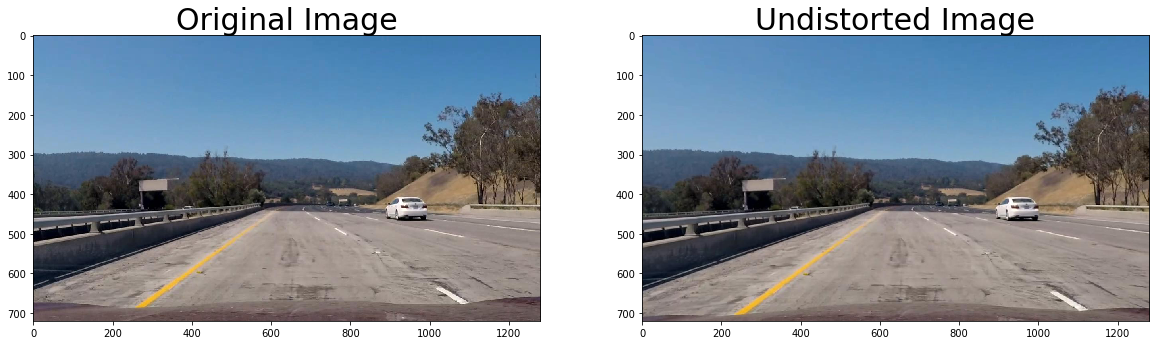

In [272]:

img = mpimg.imread('frame.jpg')

# Do camera calibration given object points and image points
#ret, mtx, dist = CalibrateCamera(cal_objpoints, cal_imgpoints, img)


dst = UnDistort(img, mtx, dist)
#cv2.imwrite('camera_cal/calibration3.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
"""dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )"""
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


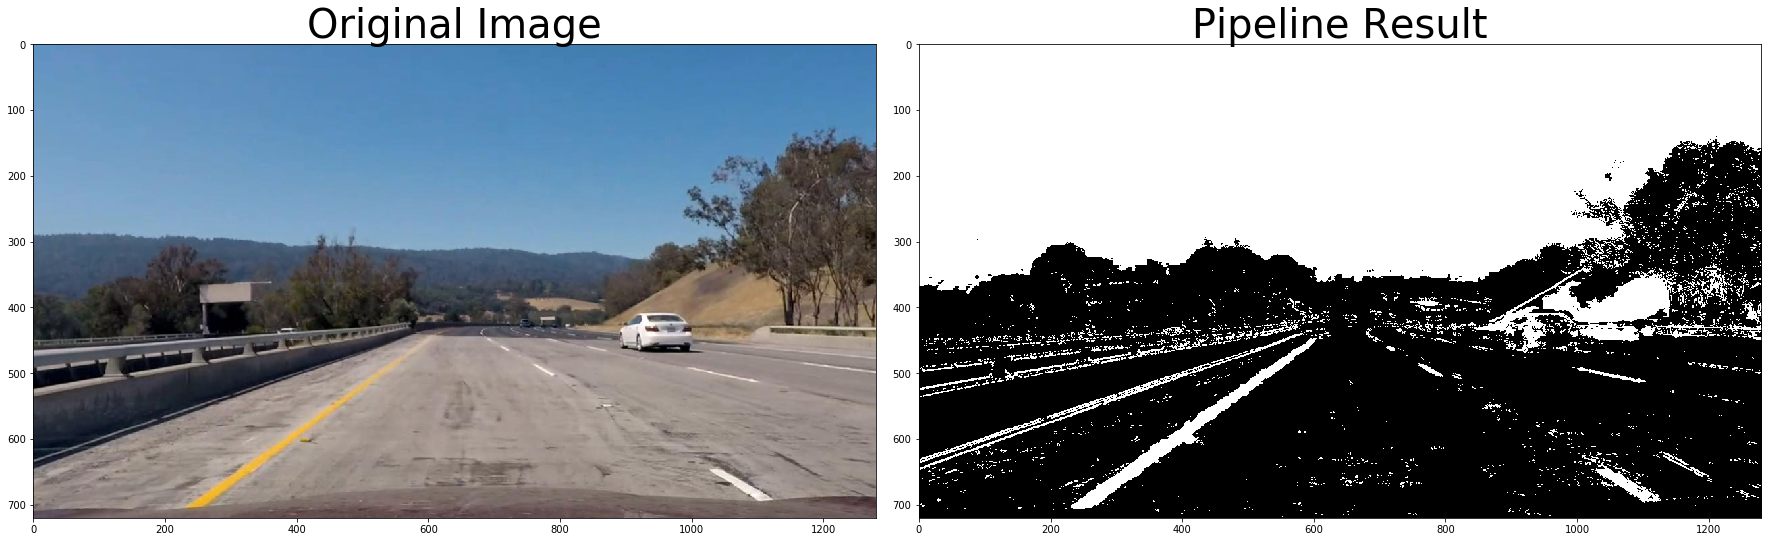

In [305]:
#img = mpimg.imread('test_images/test1.jpg')

gx_thresh=(10,255)
gy_thresh=(20,255)
cs_thresh=(50, 255)
cv_thresh=(100, 255)

gradx = abs_sobel_thresh(dst, orient='x', thresh=gx_thresh)
grady = abs_sobel_thresh(dst, orient='y', thresh=gy_thresh)

binary_image = np.zeros_like(dst[:,:,0])

color_bin = color_threshold(dst,s_thresh=cs_thresh, v_thresh=cv_thresh)
binary_image[(gradx == 1) & (grady == 1) | (color_bin == 1)] = 255
#binary_image[(color_bin == 1)] = 255
write_name = 'test_images/xundist'+str(gx_thresh[0])+','+str(gx_thresh[1])+','+str(gy_thresh[0])+','+str(gy_thresh[1])+','+str(cs_thresh[0])+','+str(cs_thresh[1])+','+str(cv_thresh[0])+','+str(cv_thresh[1])+'.jpg'

  
#warped, Minv = Unwarp(binary_image)

#combined_binary = pipeline(dst, s_thresh=(100, 255), sx_thresh=(12, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
plt.imsave(write_name, binary_image, cmap='gray')
ax1.imshow(dst)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

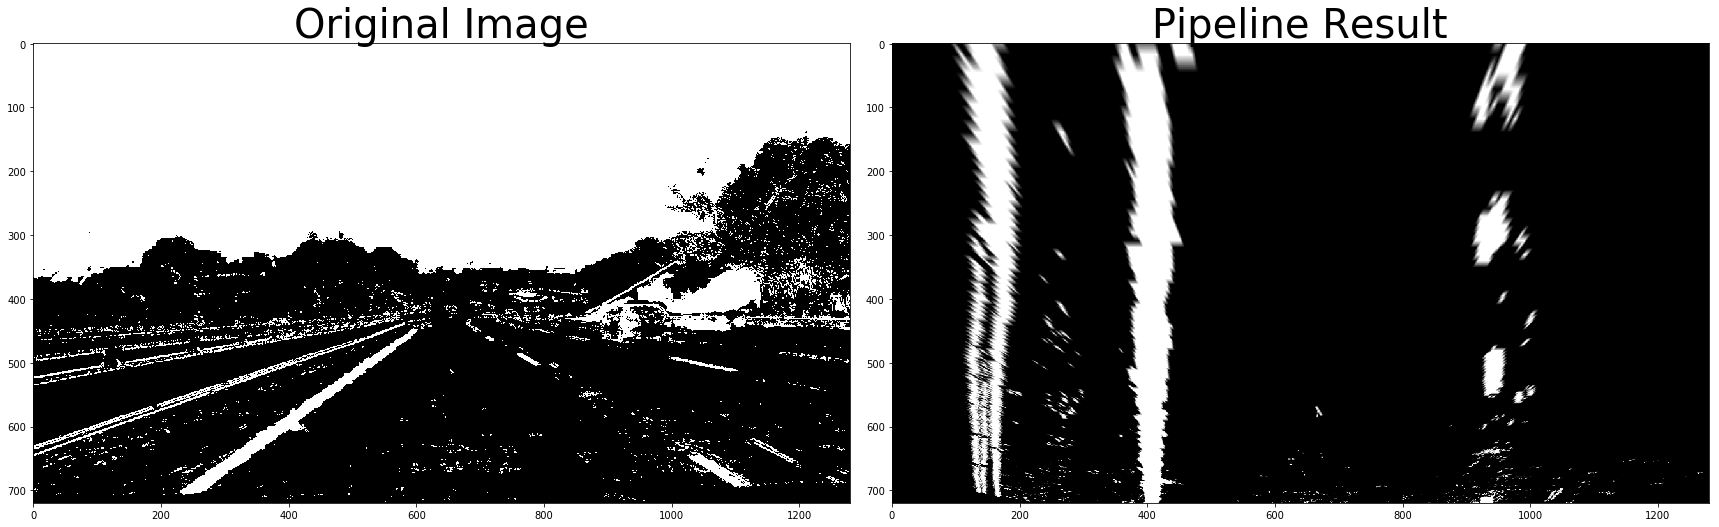

In [300]:
#copyimg = np.copy(binary_image) 

#src=np.float32([[580,460],[700,460],[1050,670],[260,670]])

binary_warped, Minv = Unwarp(binary_image)
#cv2.line(copyimg, (src[0,0],src[0,1]), (src[1,0],src[1,1]), [255, 0, 0], 5)
#cv2.line(copyimg, (src[2,0],src[2,1]), (src[1,0],src[1,1]), [255, 0, 0], 5)
#cv2.line(copyimg, (src[2,0],src[2,1]), (src[3,0],src[3,1]), [255, 0, 0], 5)
#cv2.line(copyimg, (src[0,0],src[0,1]), (src[3,0],src[3,1]), [255, 0, 0], 5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#plt.imsave('output_images/combbin_test1.jpg', combined_binary, cmap='gray')
ax1.imshow(binary_image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


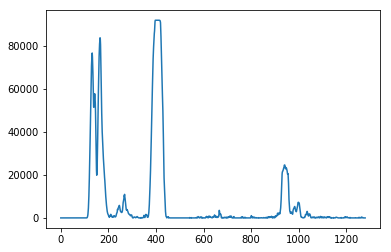

In [301]:


histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)


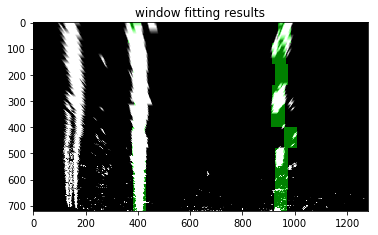

In [302]:

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
warped = np.copy(binary_warped)
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [15]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


(720, 0)

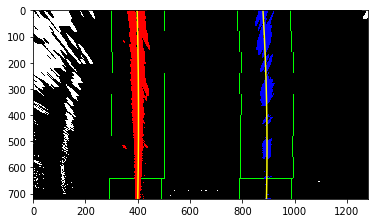

In [10]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

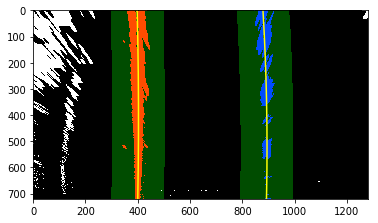

In [11]:
# Create an image to draw on and an image to show the selection window
out_img2 = np.dstack((binary_warped, binary_warped, binary_warped))*255

window_img = np.zeros_like(out_img2)
# Color in left and right line pixels
out_img2[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img2[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

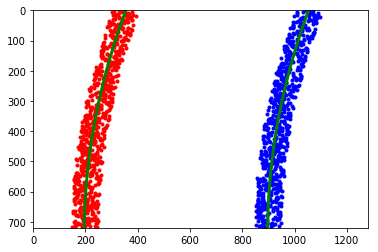

In [13]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )# to cover same y-range as image
#ploty = np.linspace(0, 719, num=720)
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [75]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)


1880.20873958 1681.06000718


In [76]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension
xm_per_pix = 3.7/1280 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


1128.49688291 m 1009.64483939 m


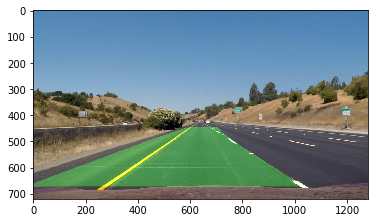

In [77]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result)